In [1]:
#Import required libraries 
import keras #library for neural network
import pandas as pd #loading data in table form  
import seaborn as sns #visualisation 
import matplotlib.pyplot as plt #visualisation
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from sklearn.preprocessing import normalize #machine learning algorithm library
from keras.models import Sequential 
from keras.layers import Dense,Activation,Dropout, LSTM
from keras.utils.vis_utils import plot_model
import math
from sklearn.metrics import r2_score

In [2]:
# #Reading data 
step=5
num_input=4
output_cluster=5 #output cluster
num_output=1 #numb of output
num_var=num_input+num_output

data=pd.read_csv("traffic_fold6.csv")
col_names=list(data)[0:5]
num_line = len(data.index)

# convert an array of values into a dataset matrix
for i in range(num_line-step):
    data.iloc[i,4]=data.iloc[i+step,1]

for i in range(step):
    data = data.drop(num_line-1)
    num_line=num_line-1
    
data_test=data
test_num_line = len(data_test.index)
data_train=data
train_num_line=len(data_train.index)
data_train

,time,lane 1,lane 2,lane 3,output
0,0.6806,0.4144,0.5124,0.3425,2.0608
1,0.6840,1.8717,1.4981,1.6181,1.9945
2,0.6875,1.6749,1.2135,1.4810,1.9118
3,0.6910,1.8391,1.2800,1.3423,1.7895
4,0.6944,1.9472,1.4428,1.5708,2.2069
...,...,...,...,...,...
811,0.4965,1.0977,0.1325,1.2077,0.9888
812,0.5000,1.0609,0.9895,1.0342,0.8202
813,0.5035,0.8593,1.2252,1.1498,1.0242
814,0.5069,0.8587,1.3435,1.0978,0.7816


In [3]:
# #Reading data 
# # train_num_line=int(num_line*0.5)
# # test_num_line = num_line - train_num_line
# test_num_line=num_line
# train_num_line=num_line

# # Create data_train = initialise dataframe (80%)
# temp = np.array([[0.0 for i in range(train_num_line)] for j in range(num_var)]).T
# # Array to dataframe :
# data_train = pd.DataFrame(temp,columns=col_names)

# # Create data_train = initialise dataframe (80%)
# temp = np.array([[0.0 for i in range(test_num_line)] for j in range(num_var)]).T
# # Array to dataframe :
# data_test = pd.DataFrame(temp,columns=col_names)

# count = 0
# train_count=0
# test_count=0

# # first half, second half, 20%
# # for i in range(num_line):
# # #     #first half
# #     if(count<train_num_line):
# # #     if (count>2*train_num_line and count<3*train_num_line+1):
# # #         print("i=",i," train_count=",train_count)
# #         data_train.iloc[train_count] = data.iloc[i]
# #         train_count=train_count+1
# #         data_test.iloc[test_count] = data.iloc[i]
# #         test_count=test_count+1
# #     ##second half
# # #     if (count>=train_num_line):
# # #     else:
# # #         print("i=",i," test_count=",test_count)
# # #         data_train.iloc[train_count] = data.iloc[i]
# # #         train_count=train_count+1
# # #         data_test.iloc[test_count] = data.iloc[i]
# # #         test_count=test_count+1
# #     count=count+1
    
# data_test=data
# data_train=data

# ##first half
# print(data_train)
# print("train_num_line ",train_num_line)

# ##second half
# print(data_test)
# print("test_num_line",test_num_line)

In [4]:
learningConst = 0.0018 #float(1/train_num_line)
mlvq_lwidth=1.5
pfkp_lwidth=0.2
epsilon = 0.0005
discreteSamplePoints=50

In [5]:
def dct(nw,data,ndx):
    e1=0
    le1=0
    e2=0
    le2=0
    neighbours = 0
    iterations=0
    min1=max1=data[0]
    
    for k in range(train_num_line):
        max1=max(max1,data[k])
        min1=min(min1,data[k])
    for j in range(1,nw.num_layers):
        lyr=nw.layers[j]
        for i in range(lyr.dim):
            lyr.neus[i].value=min1+(i+0.5)/(lyr.dim)*(max1-min1)
    
    neighbours = int(nw.layers[2].dim/5);
    interval = (max1-min1)/nw.layers[2].dim;
    
    for j in range(nw.layers[1].dim): 
        lyr = nw.layers[2]
        for i in range(lyr.dim):
            lyr.neus[i].wt[j]=0
    
    while(1):
        for k in range(train_num_line):
            winner1=findWinner(data[k],nw.layers[1])
            e1+= math.fabs(data[k]-nw.layers[1].neus[winner1].value)
            nw.layers[1].neus[winner1].value *= (1-learningConst)
            nw.layers[1].neus[winner1].value += learningConst*data[k];
            
            
            lyr = nw.layers[2];
            winner2 = findWinner(data[k], lyr);
            diff = math.fabs(data[k]-lyr.neus[winner2].value);
            lyr.neus[winner2].wt[winner1] += learningConst*(1-diff/interval)
            e2 += diff;
            
            
            i=(winner2-1)
            for l in range(2,neighbours+2):
                if i>=0:
                    diff = math.fabs(data[k]-lyr.neus[i].value)
                    lyr.neus[i].wt[winner1] += learningConst/l*(1-diff/(l*interval));
                i=i-1
                
            i=(winner2+1)
            for l in range(2,neighbours+2):
                if i<lyr.dim:
                    diff = math.fabs(data[k]-lyr.neus[i].value)
                    lyr.neus[i].wt[winner1] += learningConst/l*(1-diff/(l*interval));
                i=i+1
                
            max2 = 0
            for i in range(lyr.dim):
                max2= max(max2,lyr.neus[i].wt[winner1]);
                
                
            for i in range(lyr.dim):
                lyr.neus[i].wt[winner1] = lyr.neus[i].wt[winner1]/max2
                
        iterations=iterations+1
        
        if (math.fabs(e1-le1) <= epsilon) and (math.fabs(e2-le2) <= epsilon):
            print("No. of iterations =", iterations);
            break;
        le1 = e1
        e1 = 0
        le2 = e2
        e2 = 0
     
        
    return nw

In [6]:
def mlvq(nw,data,ndx):
    e=0
    le=0
    iterations=0
    min2=0
    widthFactor=0
    interval=0
    temp=0
    min1=max1=data[0]
    
    for k in range(train_num_line):
        max1=max(max1,data[k])
        min1=min(min1,data[k])
    for j in range(1,nw.num_layers):
        lyr=nw.layers[j]
        for i in range(lyr.dim):
            lyr.neus[i].value=min1+(i+0.5)/(lyr.dim)*(max1-min1)
    
    
    while(1):
        for k in range(train_num_line):
            winner1=findWinner(data[k],nw.layers[1])
            nw.layers[1].neus[winner1].value *= (1-learningConst)
            nw.layers[1].neus[winner1].value += learningConst*data[k];
            e+= math.fabs(data[k]-nw.layers[1].neus[winner1].value)
            
        iterations=iterations+1
        
        if (math.fabs(e-le) <= epsilon):
            print("No. of iterations =", iterations);
            break;
            
        le = e
        e = 0
        
    lyr=nw.layers[1]
    for j in range(lyr.dim):
        if (j==lyr.dim-1):
            widthFactor = math.fabs(lyr.neus[j].value - lyr.neus[j-1].value)/mlvq_lwidth
        elif (j==0):
            widthFactor = math.fabs(lyr.neus[j].value - lyr.neus[j+1].value)/mlvq_lwidth
        else:
            min2=min(math.fabs(lyr.neus[j].value - lyr.neus[j-1].value), math.fabs(lyr.neus[j].value-lyr.neus[j+1].value))
            widthFactor=min2/mlvq_lwidth
        
        interval=(max1-min1)/nw.layers[2].dim
        cur=min1
        
        for i in range(nw.layers[2].dim):
            temp=0-pow(cur-lyr.neus[j].value,2)/widthFactor
            nw.layers[2].neus[i].wt[j]=math.exp(temp)
            cur += interval
            
    return nw

In [7]:
def pfkp(nw,data,ndx):
    e=0
    le=0
    iterations=0
    min2=0
    widthFactor=0
    interval=0
    temp=0
    min1=max1=data[0]
    
    for k in range(train_num_line):
        max1=max(max1,data[k])
        min1=min(min1,data[k])
    for j in range(1,nw.num_layers):
        lyr=nw.layers[j]
        for i in range(lyr.dim):
            lyr.neus[i].value=min1+(i+0.5)/(lyr.dim)*(max1-min1)
    
    alpha=[0]*nw.layers[1].dim
    beta=[0]*nw.layers[1].dim
    sigma=[0]*nw.layers[1].dim
    tau=[0]*nw.layers[1].dim
    phi=[0]*nw.layers[1].dim
    
    
    while(1):
        for k in range(train_num_line):
            winner1=findWinner(data[k],nw.layers[1])
            nw.layers[1].neus[winner1].value *= (1-learningConst)
            nw.layers[1].neus[winner1].value += learningConst*data[k];
            e+= math.fabs(data[k]-nw.layers[1].neus[winner1].value)
            
        iterations=iterations+1
        
        if (math.fabs(e-le) <= epsilon):
            print("No. of iterations =", iterations);
            break;
            
        le = e
        e = 0
        
    le = 0 
    e = 0
    lyr = nw.layers[1]
    for j in range(lyr.dim):
        phi[j] = alpha[j] = beta[j] = sigma[j] = tau[j] = lyr.neus[j].value;
        
    for k in range(train_num_line):
        winner= findWinner(data[k], nw.layers[1])
        phi[winner] *= (1-pfkp_lwidth);
        phi[winner] += pfkp_lwidth*data[k];
        if(winner):
            alpha[winner]=sigma[winner-1]
        else:
            alpha[winner] = min(alpha[winner],data[k])
        beta[winner]= min(beta[winner],phi[winner])
        sigma[winner]= max(sigma[winner],phi[winner])
        if(winner == nw.layers[1].dim - 1):
            tau[winner]= max(tau[winner],data[k])
        else:
            tau[winner] = beta[winner+1]
            
    lyr=nw.layers[2]
    for j in range(nw.layers[1].dim):
        for i in range(lyr.dim):
            if(lyr.neus[i].value <= alpha[j] or lyr.neus[i].value >=tau[j]):
                lyr.neus[i].wt[j]=0
            elif(lyr.neus[i].value < beta[j]):
                slope = 1/(beta[j]-alpha[j])
                lyr.neus[i].wt[j] = slope * (lyr.neus[i].value - alpha[j])
            elif(lyr.neus[i].value >= beta[j] and lyr.neus[i].value <=sigma[j]):
                lyr.neus[i].wt[j]=1
            else: 
                slope = 1/(sigma[j]-tau[j])
                lyr.neus[i].wt[j]= slope * (lyr.neus[i].value - tau[j]) 
            
    return nw

In [8]:
def buildConnections(source, dest, start, step, size): #layer2->layer3, 0-3
    i=k=st=start
    for i in range(dest.dim):
        currneu=dest.neus[i]
        #newneu=[None]*8
        newneu=[neuron]*8
        newwt=[0]*8
        for k in range(currneu.num_inputs):
            newneu[k] = currneu.input[k]
            newwt[k] = currneu.wt[k]
        currneu.input=newneu
        currneu.wt = newwt
        k=st
        for k in range(st+size):
            currneu.input[currneu.num_inputs]=source.neus[k]
            currneu.wt[currneu.num_inputs]=0
            currneu.num_inputs+=currneu.num_inputs
        st+=step
    return

In [9]:
import csv
def printCluster(nw,ndx):
        
    f = open("cluster_dct.txt", "a")
    f.write(" ")
    f.write(str(nw.layers[2].dim))
    f.write("\n ")
    
    if ndx == 0:
        with open('cluster_dct.csv', 'w', newline='') as csvfile:
            spamwriter = csv.writer(csvfile, delimiter=' ')
            
            fd = open("mf_dct.txt", "a")
            print(nw.layers[2].dim)
            val=[]*nw.layers[2].dim
            for j in range(nw.layers[2].dim):
                val.append(round(nw.layers[2].neus[j].value,6))
                f.write(str(val[j]))
                f.write(" ")
                fd.write(str(val[j]))
                fd.write("\n")
            f.write("\n ")
            spamwriter.writerow(str(val))

            i=0
            wt=[0]*nw.layers[1].dim*nw.layers[2].dim
            for j in range(nw.layers[1].dim):
                for k in range(nw.layers[2].dim):
                    wt[i]=nw.layers[2].neus[k].wt[j]
                    f.write(str(round(wt[i],6)))
                    f.write(" ")
                    fd.write(str(round(wt[i],6)))
                    fd.write("\n")
                    i=i+1
                f.write("\n ")
            f.close()   
            fd.close()
            spamwriter.writerow(str(wt))
        
    else:
        with open('cluster_dct.csv', 'a', newline='') as csvfile:
            spamwriter = csv.writer(csvfile, delimiter=' ')
        
            fd = open("mf_dct.txt", "a")
            print(nw.layers[2].dim)
            val=[]*nw.layers[2].dim
            for j in range(nw.layers[2].dim):
                val.append(round(nw.layers[2].neus[j].value,6))
                f.write(str(val[j]))
                f.write(" ")
                fd.write(str(val[j]))
                fd.write("\n")
            f.write("\n ")
            spamwriter.writerow(str(val))

            i=0
            wt=[0]*nw.layers[1].dim*nw.layers[2].dim
            for j in range(nw.layers[1].dim):
                for k in range(nw.layers[2].dim):
                    wt[i]=nw.layers[2].neus[k].wt[j]
                    f.write(str(round(wt[i],6)))
                    f.write(" ")
                    fd.write(str(round(wt[i],6)))
                    fd.write("\n")
                    i=i+1
                f.write("\n ")
            f.close()   
            fd.close()
            spamwriter.writerow(str(wt))

    return

In [10]:
def findWinner(value,lyr):
    winner=0
    error=math.fabs(value-lyr.neus[0].value)
    for i in range(1,lyr.dim):
        temp=min(error, math.fabs(value-lyr.neus[i].value))
        if temp<error:
            error=temp
            winner=i
    return winner

In [11]:
#return network 
def initNN(ndx):
    x=[]
    nw=network(3)
    cent_lyr=output_cluster
    
#########################  LAYER 1: INPUT LAYER  #############################
    layer1=layer(1,0,x) #numofneurons, not ipneu, data
    nw.addLayers(0,layer1) #(layernum, layer)
    
#######################  LAYER 2: CENTROID LAYER  #############################
    layer2=layer(cent_lyr,0,x) 
    nw.addLayers(1,layer2)
#   for i in range(1):
    buildConnections(layer1,layer2,0,0,1)
    
#######################  LAYER 3: MEMBERSHIP LAYER  #############################
    layer3=layer(discreteSamplePoints,0,x)
    nw.addLayers(2,layer3) 
    for i in range(cent_lyr):
        buildConnections(layer2,layer3,i,0,1)
    f = open("cluster_dct.txt", "a")
    f.write(col_names[ndx])
    f.close()
    print(col_names[ndx])
#     nw=mlvq(nw, data_train.iloc[:,ndx],ndx)
    nw=dct(nw, data_train.iloc[:,ndx],ndx)
#     nw=pfkp(nw, data_train.iloc[:,ndx],ndx)

    printCluster(nw,ndx)
    return 

In [12]:
class network():
  def __init__(self,dim):
    self.num_layers=dim
    self.layers = [layer]*dim
  def addLayers(self,i,layer):
    self.layers[i]=layer

In [13]:
class layer(network):
  def __init__(self,dim,neu,x):
    self.dim = dim
    self.neus = [neuron]*dim
    self.ipneus=[ipneuron]*dim
    self.count=0
    for i in range(dim):
        if neu == 0:
            self.neus[i]=neuron(dim)
        elif neu==1:
            self.ipneus[i]=ipneuron(dim,i,x)

In [14]:
class neuron(layer):
  def __init__(self,dim):
    self.name = None
    self.value = 0
    self.num_inputs = 0
    self.input = [neuron]*pow(output_cluster,num_var)
    self.wt= [0]*pow(output_cluster,num_var)
    self.combFunc=-1
    self.actFunc=-1
    self.activation=0
    self.ip_type=1
    self.ipneu_input = [ipneuron]
    self.actFunc_arg=[0]

In [15]:
class ipneuron(layer):
  def __init__(self,dim,count,x):
    self.numPt=discreteSamplePoints
    self.ip_value=0
    self.value=[0]*output_cluster #num_pattern
    self.name=col_names[count]
    self.mf = [[0 for i in range(discreteSamplePoints)] for j in range(output_cluster+1)]
    self.cluster=0
    for i in range(output_cluster+1):
        for j in range(discreteSamplePoints):
#             print("input",(discreteSamplePoints*i)+j+(count*(discreteSamplePoints*(output_cluster+1))))
#             print("value:",x[(discreteSamplePoints*i)+j+(count*(discreteSamplePoints*(output_cluster+1)))] )
            self.mf[i][j]=x[(discreteSamplePoints*i)+j+(count*(discreteSamplePoints*(output_cluster+1)))]
    if(count==num_input-1):
        count=count+1
        for i in range(output_cluster+1):
            for j in range(discreteSamplePoints):
#                 print("output",(discreteSamplePoints*i)+j+(count*(discreteSamplePoints*(output_cluster+1))))
#                 print("value:",x[(discreteSamplePoints*i)+j+(count*(discreteSamplePoints*(output_cluster+1)))] )
                Outmf[i][j]=x[(discreteSamplePoints*i)+j+(count*(discreteSamplePoints*(output_cluster+1)))]

In [16]:
def findWinner1(value,pt,numPt):
    winner=0
    error=math.fabs(value-pt[0])
    for i in range(1,numPt):
        temp=min(error, math.fabs(value-pt[i]))
        if temp<error:
            error=temp
            winner=i
    return winner

In [17]:
def initNN1(x):
    nw = network(6)
    nw.num_feature=num_input #input
    nw.num_pattern=output_cluster #out
    
#########################  LAYER 1: INPUT LAYER  #############################
    
    # create input layer
    lyr=layer(num_input,1,x) #dim,input neu, dataset
    nw.addLayers(0,lyr)
    
#     print("layer 1 with ",nw.layers[0].dim," neurons\n");
#     for j in range(nw.layers[0].dim):
#         print("membership function of")
#         print(nw.layers[0].ipneus[j].mf,"\n")
        
        
#     print("membership function of \n")
#     print(Outmf,"\n") 

#######################  LAYER 2: ANTECEDENT LAYER  #############################
    
    # create antecedent layer
    lyr=layer(num_input*output_cluster,0,x) #dim, not input neu, dataset
    nw.addLayers(1,lyr)
    
    # make connections between antecedent and input layers
    for i in range(num_input):
        for j in range(output_cluster):
            neu = lyr.neus[i*output_cluster+j]
            neu.ip_type=0
            neu.ipneu_input[0]=nw.layers[0].ipneus[i]
            neu.wt[0]=1.0
            neu.num_inputs=1
        
    
#######################  LAYER 3: RULE LAYER  #############################
    
    # create rule layer
    lyr=layer(pow(output_cluster,num_var),0,x) #dim, not input neu, dataset
    nw.addLayers(2,lyr)
    

##################  LAYER 4: CONSEQUENT LAYER  #############################
    
    # create output label layer
    lyr = layer(output_cluster,0,x)
    nw.addLayers(3,lyr)

##################  LAYER 5: OUTPUT POSSIBILITY LAYER  #############################
    
    # create output possibility layer
    lyr = layer(output_cluster,0,x)
    nw.addLayers(4,lyr)
    
    yagerTest(nw)
    return

In [18]:
def yagerTest(nw):
    from sklearn.metrics import r2_score
    RMSE=0
    result=[0]*test_num_line
    time=[0]*test_num_line
    train_x = (data_train.iloc[:,[0,1,2,3]]).values
    train_y = (data_train.iloc[:,[4]]).values
    test_x = (data_test.iloc[:,[0,1,2,3]]).values
    test_y = (data_test.iloc[:,[4]]).values
    global outputCluster
    #print(feature)

    ## train - rule creation
    for i in range(train_num_line):
        processRule_train(nw,train_x[i],train_y[i],i)
    inputCluster=processInput_train(nw)
    outputCluster=processOutput_train(nw)
    currentRule=processRule()
    
    ## test - process the dataset using the rules created
    for i in range(test_num_line):
        inputCluster_test=processInput_test(nw,test_x[i],test_y[i],i)
        result[i]=processOutput(inputCluster_test,outputCluster, currentRule)
    
    f = open("result_yagernetwork.txt", "w")
    
    print("\npredicted vs actual output")
    f.write("predicted vs actual output\n")
    for i in range(test_num_line):
        print(" ", '{0:.2f}'.format(result[i]),"  ",'{0:.2f}'.format(test_y[i][0]))
        f.write(str( '{0:.2f}'.format(result[i])))
        f.write("  ")
        f.write(str('{0:.2f}'.format(test_y[i][0])))
        f.write("\n")
        time[i]=i

    from matplotlib import pyplot as plt
    plt.plot(time, result, 'r-')
    plt.plot(time, test_y, 'b-')
    plt.xlabel("Time (s)")
    plt.ylabel("Normal Density")
    
    from sklearn.metrics import mean_squared_error
    rms = mean_squared_error(test_y, result)
    print("RMSE = ",rms)
    f.write("RMSE = ")
    f.write(str(rms))
    TestR2Value = r2_score(test_y,result)
    print("Testing Set R-Square=", TestR2Value)
    f.write("R-Square=")
    f.write(str(TestR2Value))

    
#     mlp_main(fuzzytrain_x,fuzzytrain_y,train_y,fuzzytest_x, fuzzytest_y,test_y,outputCluster)
        
    return

In [19]:
def processOutput(x,outputCluster,currentRule):
    for i in range(len(currentRule)):
#         print("rule: ",currentRule[i],"&& input: ",x)
        if(currentRule[i][0]==x[0] and currentRule[i][1]==x[1] and currentRule[i][2]==x[2]):
#             print("FOUND: rule: ",currentRule[i],"&& input: ",x)
#             print("output cluster: ",currentRule[i][4])
            return outputCluster[currentRule[i][3]]
        elif(i==len(currentRule)-1):
#             print("NOT FOUND: rule: ",currentRule[i],"&& input: ",x)
            return 0

In [20]:
def processRule():
    updatedRule=[[0 for i in range(num_var+1)] for j in range(ruleCount)]
    temp=[[0 for i in range(num_var+1)] for j in range(ruleCount)]
    count=0
    
    for i in range(ruleCount):
        for j in range(num_var+1):
            updatedRule[i][j]=rules[i][j]
#     print("updated", updatedRule)
            
    for i in range(ruleCount):
        tempval=0
        tempindex=0
        for j in range(i+1,ruleCount):
            if(updatedRule[i][0]==updatedRule[j][0] and updatedRule[i][1]==updatedRule[j][1] and updatedRule[i][2]==updatedRule[j][2] and updatedRule[i][num_var]!=-1):
#                 print("same inputs ","i: ",updatedRule[i],"  j: ",updatedRule[j])
                if(updatedRule[i][num_var]>updatedRule[j][num_var] and updatedRule[i][num_var]>tempval):
                    tempval=updatedRule[i][num_var]
                    tempindex=i
#                     print("updatedRule[i][5]>updatedRule[j][5] and updatedRule[i][5]>tempval: ",tempval)
                elif(updatedRule[j][num_var]>updatedRule[i][num_var] and updatedRule[j][num_var]>tempval):
                    tempval=updatedRule[j][num_var]
                    tempindex=j
#                     print("updatedRule[j][5]>updatedRule[i][5] and updatedRule[j][5]>tempval: ",tempval)
        if(tempval!=0 and updatedRule[i][num_var]!=-1):
            temp[count]=updatedRule[tempindex]
            count=count+1
        elif(updatedRule[i][num_var]!=-1):
#             print("diff inputs ",updatedRule[i])
            temp[count]=updatedRule[i]
            count=count+1
        for j in range(ruleCount):
            updatedRule[i][num_var]=-1
            if(updatedRule[i][0]==updatedRule[j][0] and updatedRule[i][1]==updatedRule[j][1] and updatedRule[i][2]==updatedRule[j][2]):
                updatedRule[j][num_var]=-1
        
    currentRule=[[0 for i in range(num_var)] for j in range(count)]    
    for i in range(count):
        for j in range(num_var):
            currentRule[i][j]=temp[i][j]
    
#     print("temp", temp)
    print("currentRule", currentRule)
    return currentRule

In [21]:
def processInput_test(nw,x,y,count):
    value=[0]*output_cluster
    inputCluster=[0]*num_input
    
    ##find the similarity score for input value
    for i in range(num_input):
        ipneu=nw.layers[0].ipneus[i]
        ipneu.ip_value=x[i]
        mf=ipneu.mf
        winner=findWinner1(x[i],mf[0],ipneu.numPt)
        for j in range(output_cluster):
            ipneu.value[j] = mf[j+1][winner]
            fuzzytest_mlp.iloc[count][(i*output_cluster)+j]=mf[j+1][winner]
            fuzzytest_ltsm.iloc[count][(i*output_cluster)+j]=mf[j+1][winner]#ipneu.value[j]
            
    ##find the cluster it belongs to for the input value        
    for i in range(num_input):
        temp=0
        for j in range(output_cluster):
            if(nw.layers[0].ipneus[i].value[j]>=temp):
                nw.layers[0].ipneus[i].cluster=j
                temp=nw.layers[0].ipneus[i].value[j]

    for i in range(num_input):
        inputCluster[i]=nw.layers[0].ipneus[i].cluster
#         print("input cluster ",inputCluster[i])

    for i in range(num_input):
        print("test input: ",x[i]," cluster: ",nw.layers[0].ipneus[i].cluster) 

    ##find the similarity score for output value             
    winner=findWinner1(y[0],Outmf[0],ipneu.numPt)
    for j in range(output_cluster):
        value[j] = Outmf[j+1][winner]
    fuzzytest_ltsm.iloc[count][(num_input*output_cluster)]= y[0]

    ##find the cluster it belongs to for the output value             
    temp=0
    for j in range(output_cluster):
        if(value[j]>=temp):
            cluster=j
            temp=value[j]

    print("output cluster ",cluster) 
    fuzzytest_mlp.iloc[count][(num_input*output_cluster)]=cluster
    
    return inputCluster

In [22]:
def processRule_train(nw,x,y,count):
    value=[0]*output_cluster
    actualValue=[0]*output_cluster
    global ruleCount
    
    ##find the similarity score for input value
    for i in range(num_input):
        ipneu=nw.layers[0].ipneus[i]
        ipneu.ip_value=x[i]
        mf=ipneu.mf
        winner=findWinner1(x[i],mf[0],ipneu.numPt)
        for j in range(output_cluster):
            ipneu.value[j] = mf[j+1][winner]
            fuzzytrain_ltsm.iloc[count][(i*output_cluster)+j]=mf[j+1][winner]#ipneu.value[j]
            fuzzytrain_mlp.iloc[count][(i*output_cluster)+j]=mf[j+1][winner]

            
    ##find the cluster it belongs to for the input value        
    for i in range(num_input):
        temp=0
        for j in range(output_cluster):
            if(nw.layers[0].ipneus[i].value[j]>=temp):
                nw.layers[0].ipneus[i].cluster=j
                temp=nw.layers[0].ipneus[i].value[j]
                
    ##find the similarity score for output value             
    winner=findWinner1(y[0],Outmf[0],ipneu.numPt)
    for j in range(output_cluster):
        value[j] = Outmf[j+1][winner]
    fuzzytrain_ltsm.iloc[count][(num_input*output_cluster)]= y[0]
        
    ##find the cluster it belongs to for the output value             
    temp=0
    for j in range(output_cluster):
        if(value[j]>=temp):
            cluster=j
            temp=value[j]
            
    fuzzytrain_mlp.iloc[count][(num_input*output_cluster)]=cluster

    for i in range(num_input):
        print("train input cluster ",nw.layers[0].ipneus[i].cluster) 
    print("train output cluster ",cluster) 

    createNewRule=0
    ##create rules
    for i in range(ruleCount+1):
        sameClusters=0
        for j in range(num_var):
            if(j<num_input): ##check input of rule
                if (rules[i][j]==nw.layers[0].ipneus[j].cluster):
                    sameClusters+=1
            else: ##check ouput of rule
                if(rules[i][j]==cluster):
                    sameClusters+=1
        if (sameClusters==num_var):
            rules[i][num_var]+=1
            break
        elif (i==ruleCount):
            createNewRule=1  
    if createNewRule==1:
        for i in range(num_input):
            rules[ruleCount][i]=nw.layers[0].ipneus[i].cluster
        rules[ruleCount][num_var-1]=cluster
        rules[ruleCount][num_var]=1
        ruleCount+=1

In [23]:
def processOutput_train(nw):
    fuzzyValue=[0]*output_cluster
        
#     for i in range(output_cluster):
#         for j in range(discreteSamplePoints):
#             if (Outmf[i+1][j]==1.0):
#                 fuzzyValue[i]=Outmf[0][j]
    for k in range(output_cluster):
        tempValue=0
        tempIndex=0
        for j in range(discreteSamplePoints):
            if(Outmf[k+1][j]>tempValue): 
                tempValue=Outmf[k+1][j]
                tempIndex=j
        fuzzyValue[k]=Outmf[0][tempIndex]
                
    return fuzzyValue

In [24]:
def processInput_train(nw):
#     mf=[[0 for i in range(discreteSamplePoints)] for j in range(output_cluster+1)]
    fuzzyValue=[[0 for i in range((output_cluster))] for j in range(num_input)] 
    tempValue=0
    tempIndex=0
    ##find the similarity score for input value
    for i in range(num_input):
        ipneu=nw.layers[0].ipneus[i]
        mf=ipneu.mf
        for k in range(output_cluster):
            tempValue=0
            tempIndex=0
            for j in range(discreteSamplePoints):
                if(mf[k+1][j]>tempValue): 
                    tempValue=mf[k+1][j]
                    tempIndex=j
            fuzzyValue[i][k]=mf[0][tempIndex]
    
    return fuzzyValue

time
No. of iterations = 18
50
lane 1
No. of iterations = 214
50
lane 2
No. of iterations = 177
50
lane 3
No. of iterations = 150
50
output
No. of iterations = 245
50
1500
train input cluster  3
train input cluster  0
train input cluster  0
train input cluster  0
train output cluster  4
train input cluster  3
train input cluster  3
train input cluster  3
train input cluster  3
train output cluster  4
train input cluster  3
train input cluster  3
train input cluster  2
train input cluster  3
train output cluster  4
train input cluster  3
train input cluster  3
train input cluster  2
train input cluster  2
train output cluster  3
train input cluster  3
train input cluster  4
train input cluster  3
train input cluster  3
train output cluster  4
train input cluster  3
train input cluster  4
train input cluster  3
train input cluster  3
train output cluster  4
train input cluster  3
train input cluster  4
train input cluster  3
train input cluster  4
train output cluster  4
train input clus

train input cluster  4
train input cluster  2
train input cluster  3
train input cluster  3
train output cluster  2
train input cluster  4
train input cluster  2
train input cluster  2
train input cluster  2
train output cluster  1
train input cluster  4
train input cluster  1
train input cluster  2
train input cluster  2
train output cluster  1
train input cluster  4
train input cluster  2
train input cluster  2
train input cluster  3
train output cluster  1
train input cluster  4
train input cluster  1
train input cluster  2
train input cluster  2
train output cluster  1
train input cluster  4
train input cluster  2
train input cluster  2
train input cluster  2
train output cluster  1
train input cluster  4
train input cluster  1
train input cluster  2
train input cluster  2
train output cluster  1
train input cluster  4
train input cluster  1
train input cluster  1
train input cluster  1
train output cluster  1
train input cluster  4
train input cluster  1
train input cluster  2
tra

train input cluster  1
train input cluster  0
train input cluster  0
train input cluster  0
train output cluster  0
train input cluster  1
train input cluster  0
train input cluster  0
train input cluster  0
train output cluster  0
train input cluster  1
train input cluster  0
train input cluster  0
train input cluster  0
train output cluster  0
train input cluster  1
train input cluster  0
train input cluster  0
train input cluster  0
train output cluster  0
train input cluster  1
train input cluster  0
train input cluster  0
train input cluster  0
train output cluster  0
train input cluster  1
train input cluster  0
train input cluster  0
train input cluster  0
train output cluster  0
train input cluster  1
train input cluster  0
train input cluster  0
train input cluster  0
train output cluster  0
train input cluster  1
train input cluster  0
train input cluster  0
train input cluster  0
train output cluster  0
train input cluster  1
train input cluster  0
train input cluster  0
tra

train input cluster  2
train input cluster  2
train output cluster  2
train input cluster  2
train input cluster  3
train input cluster  2
train input cluster  2
train output cluster  4
train input cluster  2
train input cluster  3
train input cluster  2
train input cluster  1
train output cluster  2
train input cluster  2
train input cluster  3
train input cluster  2
train input cluster  2
train output cluster  2
train input cluster  2
train input cluster  3
train input cluster  2
train input cluster  2
train output cluster  3
train input cluster  2
train input cluster  2
train input cluster  2
train input cluster  1
train output cluster  2
train input cluster  2
train input cluster  4
train input cluster  2
train input cluster  1
train output cluster  2
train input cluster  2
train input cluster  2
train input cluster  1
train input cluster  1
train output cluster  3
train input cluster  2
train input cluster  2
train input cluster  1
train input cluster  1
train output cluster  2
tr

train input cluster  4
train input cluster  2
train input cluster  2
train input cluster  3
train output cluster  2
train input cluster  4
train input cluster  2
train input cluster  2
train input cluster  3
train output cluster  2
train input cluster  4
train input cluster  2
train input cluster  2
train input cluster  2
train output cluster  1
train input cluster  4
train input cluster  2
train input cluster  2
train input cluster  2
train output cluster  2
train input cluster  4
train input cluster  2
train input cluster  2
train input cluster  2
train output cluster  1
train input cluster  4
train input cluster  2
train input cluster  2
train input cluster  1
train output cluster  2
train input cluster  4
train input cluster  2
train input cluster  2
train input cluster  1
train output cluster  1
train input cluster  4
train input cluster  1
train input cluster  3
train input cluster  2
train output cluster  1
train input cluster  4
train input cluster  2
train input cluster  2
tra

train input cluster  0
train input cluster  0
train input cluster  0
train input cluster  0
train output cluster  0
train input cluster  0
train input cluster  0
train input cluster  0
train input cluster  0
train output cluster  0
train input cluster  0
train input cluster  0
train input cluster  0
train input cluster  0
train output cluster  0
train input cluster  0
train input cluster  0
train input cluster  0
train input cluster  0
train output cluster  0
train input cluster  0
train input cluster  0
train input cluster  0
train input cluster  0
train output cluster  0
train input cluster  0
train input cluster  0
train input cluster  0
train input cluster  0
train output cluster  0
train input cluster  0
train input cluster  0
train input cluster  0
train input cluster  0
train output cluster  0
train input cluster  0
train input cluster  0
train input cluster  0
train input cluster  0
train output cluster  0
train input cluster  0
train input cluster  0
train input cluster  0
tra

train input cluster  2
train input cluster  2
train input cluster  2
train input cluster  3
train output cluster  3
train input cluster  2
train input cluster  2
train input cluster  2
train input cluster  2
train output cluster  2
train input cluster  2
train input cluster  3
train input cluster  2
train input cluster  2
train output cluster  3
train input cluster  2
train input cluster  3
train input cluster  2
train input cluster  2
train output cluster  2
train input cluster  2
train input cluster  2
train input cluster  2
train input cluster  1
train output cluster  2
train input cluster  2
train input cluster  3
train input cluster  2
train input cluster  1
train output cluster  3
train input cluster  2
train input cluster  2
train input cluster  3
train input cluster  2
train output cluster  3
train input cluster  2
train input cluster  3
train input cluster  2
train input cluster  2
train output cluster  3
train input cluster  2
train input cluster  2
train input cluster  2
tra

train input cluster  3
train input cluster  3
train input cluster  3
train input cluster  3
train output cluster  3
train input cluster  3
train input cluster  3
train input cluster  3
train input cluster  4
train output cluster  3
train input cluster  3
train input cluster  3
train input cluster  3
train input cluster  4
train output cluster  3
train input cluster  3
train input cluster  3
train input cluster  3
train input cluster  3
train output cluster  3
train input cluster  3
train input cluster  3
train input cluster  3
train input cluster  3
train output cluster  3
train input cluster  3
train input cluster  3
train input cluster  3
train input cluster  4
train output cluster  3
train input cluster  3
train input cluster  3
train input cluster  3
train input cluster  4
train output cluster  2
train input cluster  3
train input cluster  3
train input cluster  3
train input cluster  3
train output cluster  2
train input cluster  3
train input cluster  3
train input cluster  3
tra

train input cluster  1
train output cluster  0
train input cluster  0
train input cluster  1
train input cluster  0
train input cluster  0
train output cluster  0
train input cluster  0
train input cluster  0
train input cluster  0
train input cluster  0
train output cluster  1
train input cluster  0
train input cluster  0
train input cluster  1
train input cluster  0
train output cluster  0
train input cluster  0
train input cluster  0
train input cluster  1
train input cluster  0
train output cluster  0
train input cluster  0
train input cluster  0
train input cluster  0
train input cluster  0
train output cluster  0
train input cluster  0
train input cluster  0
train input cluster  0
train input cluster  0
train output cluster  0
train input cluster  0
train input cluster  1
train input cluster  1
train input cluster  0
train output cluster  0
train input cluster  0
train input cluster  0
train input cluster  1
train input cluster  0
train output cluster  0
train input cluster  0
tr

train input cluster  1
train input cluster  1
train input cluster  1
train input cluster  1
train output cluster  1
train input cluster  1
train input cluster  1
train input cluster  1
train input cluster  1
train output cluster  1
train input cluster  1
train input cluster  1
train input cluster  1
train input cluster  1
train output cluster  1
train input cluster  1
train input cluster  1
train input cluster  1
train input cluster  1
train output cluster  1
train input cluster  1
train input cluster  1
train input cluster  2
train input cluster  1
train output cluster  0
train input cluster  1
train input cluster  1
train input cluster  1
train input cluster  1
train output cluster  1
train input cluster  1
train input cluster  1
train input cluster  1
train input cluster  1
train output cluster  1
train input cluster  1
train input cluster  1
train input cluster  1
train input cluster  1
train output cluster  1
train input cluster  1
train input cluster  1
train input cluster  1
tra

test input:  0.7778  cluster:  3
test input:  1.6876  cluster:  3
test input:  1.5866  cluster:  3
test input:  1.9073  cluster:  3
output cluster  3
test input:  0.7813  cluster:  3
test input:  1.8047  cluster:  3
test input:  1.1984  cluster:  2
test input:  1.7013  cluster:  3
output cluster  2
test input:  0.7847  cluster:  3
test input:  1.6219999999999999  cluster:  3
test input:  1.4269  cluster:  3
test input:  1.754  cluster:  3
output cluster  3
test input:  0.7882  cluster:  3
test input:  1.8839  cluster:  3
test input:  1.3307  cluster:  2
test input:  1.795  cluster:  3
output cluster  3
test input:  0.7917  cluster:  3
test input:  1.8634  cluster:  3
test input:  1.6924  cluster:  3
test input:  1.9028  cluster:  3
output cluster  3
test input:  0.7951  cluster:  3
test input:  1.514  cluster:  3
test input:  1.5212  cluster:  3
test input:  1.9056  cluster:  3
output cluster  3
test input:  0.7986  cluster:  3
test input:  1.3694  cluster:  2
test input:  1.485  clust

test input:  0.0725  cluster:  0
output cluster  0
test input:  0.0694  cluster:  0
test input:  0.1808  cluster:  0
test input:  0.248  cluster:  0
test input:  0.0587  cluster:  0
output cluster  0
test input:  0.0729  cluster:  0
test input:  0.1661  cluster:  0
test input:  0.2432  cluster:  0
test input:  0.0649  cluster:  0
output cluster  0
test input:  0.0764  cluster:  0
test input:  0.2063  cluster:  0
test input:  0.2635  cluster:  0
test input:  0.0269  cluster:  0
output cluster  0
test input:  0.0799  cluster:  0
test input:  0.2648  cluster:  0
test input:  0.3566  cluster:  0
test input:  0.0127  cluster:  0
output cluster  0
test input:  0.0833  cluster:  0
test input:  0.2159  cluster:  0
test input:  0.2517  cluster:  0
test input:  0.0254  cluster:  0
output cluster  0
test input:  0.0868  cluster:  0
test input:  0.151  cluster:  0
test input:  0.2412  cluster:  0
test input:  0.0115  cluster:  0
output cluster  0
test input:  0.0903  cluster:  0
test input:  0.174

test input:  0.3507  cluster:  1
test input:  1.7626  cluster:  3
test input:  1.5754  cluster:  3
test input:  2.475  cluster:  4
output cluster  4
test input:  0.3542  cluster:  1
test input:  1.7928  cluster:  3
test input:  1.8107  cluster:  4
test input:  2.6074  cluster:  4
output cluster  4
test input:  0.3576  cluster:  1
test input:  2.0521  cluster:  4
test input:  2.0337  cluster:  4
test input:  2.7271  cluster:  4
output cluster  4
test input:  0.3611  cluster:  1
test input:  2.1895  cluster:  4
test input:  1.9809999999999999  cluster:  4
test input:  2.6531  cluster:  4
output cluster  4
test input:  0.3646  cluster:  1
test input:  2.5142  cluster:  4
test input:  2.5162  cluster:  4
test input:  2.763  cluster:  4
output cluster  4
test input:  0.3681  cluster:  1
test input:  2.1322  cluster:  4
test input:  2.428  cluster:  4
test input:  2.7459  cluster:  4
output cluster  3
test input:  0.3715  cluster:  1
test input:  2.3758  cluster:  4
test input:  2.4368  clus

test input:  1.655  cluster:  3
test input:  1.3035  cluster:  2
test input:  1.4254  cluster:  2
output cluster  3
test input:  0.6111  cluster:  3
test input:  1.6856  cluster:  3
test input:  1.3382  cluster:  2
test input:  1.4828  cluster:  3
output cluster  3
test input:  0.6146  cluster:  3
test input:  1.5658  cluster:  3
test input:  0.4213  cluster:  0
test input:  1.3599  cluster:  2
output cluster  4
test input:  0.6181  cluster:  3
test input:  1.7278  cluster:  3
test input:  1.1786  cluster:  2
test input:  1.5096  cluster:  3
output cluster  4
test input:  0.6215  cluster:  3
test input:  1.7523  cluster:  3
test input:  1.4283  cluster:  3
test input:  1.6519  cluster:  3
output cluster  3
test input:  0.625  cluster:  3
test input:  1.6933  cluster:  3
test input:  1.5515  cluster:  3
test input:  1.5064  cluster:  3
output cluster  4
test input:  0.6285  cluster:  3
test input:  1.8101  cluster:  3
test input:  1.6459  cluster:  3
test input:  1.7398  cluster:  3
out

test input:  0.8542  cluster:  4
test input:  1.3853  cluster:  2
test input:  1.2408  cluster:  2
test input:  1.4889  cluster:  3
output cluster  2
test input:  0.8576  cluster:  4
test input:  1.1401  cluster:  2
test input:  1.4634  cluster:  3
test input:  1.7475  cluster:  3
output cluster  2
test input:  0.8611  cluster:  4
test input:  1.4068  cluster:  2
test input:  1.3781  cluster:  3
test input:  1.7771  cluster:  3
output cluster  2
test input:  0.8646  cluster:  4
test input:  1.3205  cluster:  2
test input:  1.1808  cluster:  2
test input:  1.4742  cluster:  3
output cluster  2
test input:  0.8681  cluster:  4
test input:  1.411  cluster:  2
test input:  1.3526  cluster:  3
test input:  1.6056  cluster:  3
output cluster  2
test input:  0.8715  cluster:  4
test input:  1.3645  cluster:  2
test input:  1.3085  cluster:  2
test input:  1.5218  cluster:  3
output cluster  2
test input:  0.875  cluster:  4
test input:  1.3556  cluster:  2
test input:  1.104  cluster:  2
test

test input:  0.2313  cluster:  0
test input:  0.3617  cluster:  0
test input:  0.0565  cluster:  0
output cluster  0
test input:  0.1042  cluster:  0
test input:  0.2669  cluster:  0
test input:  0.3681  cluster:  0
test input:  0.0992  cluster:  0
output cluster  0
test input:  0.1076  cluster:  0
test input:  0.1895  cluster:  0
test input:  0.3448  cluster:  0
test input:  0.040999999999999995  cluster:  0
output cluster  0
test input:  0.1111  cluster:  0
test input:  0.2124  cluster:  0
test input:  0.4027  cluster:  0
test input:  0.1005  cluster:  0
output cluster  0
test input:  0.1146  cluster:  0
test input:  0.0757  cluster:  0
test input:  0.4367  cluster:  0
test input:  0.0396  cluster:  0
output cluster  0
test input:  0.1181  cluster:  0
test input:  0.175  cluster:  0
test input:  0.3488  cluster:  0
test input:  0.0509  cluster:  0
output cluster  0
test input:  0.1215  cluster:  0
test input:  0.2586  cluster:  0
test input:  0.3631  cluster:  0
test input:  0.0335  

test input:  0.3715  cluster:  1
test input:  1.7376  cluster:  3
test input:  1.4453  cluster:  3
test input:  1.7374  cluster:  3
output cluster  3
test input:  0.375  cluster:  1
test input:  1.8493  cluster:  3
test input:  1.2962  cluster:  2
test input:  1.6754  cluster:  3
output cluster  2
test input:  0.3785  cluster:  1
test input:  1.7182  cluster:  3
test input:  1.5284  cluster:  3
test input:  2.0258  cluster:  4
output cluster  3
test input:  0.3819  cluster:  1
test input:  1.4105  cluster:  2
test input:  1.4232  cluster:  3
test input:  1.472  cluster:  3
output cluster  3
test input:  0.3854  cluster:  2
test input:  2.1594  cluster:  4
test input:  1.5937  cluster:  3
test input:  1.9071  cluster:  3
output cluster  0
test input:  0.3889  cluster:  2
test input:  1.5141  cluster:  3
test input:  1.4625  cluster:  3
test input:  1.5827  cluster:  3
output cluster  1
test input:  0.3924  cluster:  2
test input:  1.3227  cluster:  2
test input:  1.3015  cluster:  2
tes

test input:  1.2344  cluster:  2
test input:  1.3211  cluster:  2
test input:  1.5330000000000001  cluster:  3
output cluster  2
test input:  0.625  cluster:  3
test input:  1.4126  cluster:  2
test input:  1.3289  cluster:  2
test input:  1.62  cluster:  3
output cluster  3
test input:  0.6285  cluster:  3
test input:  1.3538  cluster:  2
test input:  1.3784  cluster:  3
test input:  1.3155  cluster:  2
output cluster  2
test input:  0.6319  cluster:  3
test input:  1.3467  cluster:  2
test input:  1.5261  cluster:  3
test input:  1.4591  cluster:  3
output cluster  2
test input:  0.6354  cluster:  3
test input:  1.2647  cluster:  2
test input:  1.3713  cluster:  3
test input:  1.579  cluster:  3
output cluster  3
test input:  0.6389  cluster:  3
test input:  1.3111  cluster:  2
test input:  1.2092  cluster:  2
test input:  1.3303  cluster:  2
output cluster  2
test input:  0.6424  cluster:  3
test input:  1.5891  cluster:  3
test input:  1.0925  cluster:  2
test input:  1.3773  clust

test input:  1.115  cluster:  2
output cluster  1
test input:  0.8715  cluster:  4
test input:  1.1063  cluster:  2
test input:  1.1171  cluster:  2
test input:  1.3496  cluster:  2
output cluster  2
test input:  0.875  cluster:  4
test input:  1.075  cluster:  2
test input:  1.3421  cluster:  2
test input:  1.2296  cluster:  2
output cluster  1
test input:  0.8785  cluster:  4
test input:  1.0642  cluster:  2
test input:  1.4208  cluster:  3
test input:  1.2011  cluster:  2
output cluster  1
test input:  0.8819  cluster:  4
test input:  1.0529  cluster:  2
test input:  1.3422  cluster:  2
test input:  1.5664  cluster:  3
output cluster  2
test input:  0.8854  cluster:  4
test input:  0.9502  cluster:  1
test input:  1.2137  cluster:  2
test input:  0.9431  cluster:  1
output cluster  1
test input:  0.8889  cluster:  4
test input:  1.0508  cluster:  2
test input:  1.3298  cluster:  2
test input:  1.2456  cluster:  2
output cluster  1
test input:  0.8924  cluster:  4
test input:  0.8059

test input:  0.1354  cluster:  0
test input:  0.1896  cluster:  0
test input:  0.4167  cluster:  0
test input:  0.0565  cluster:  0
output cluster  0
test input:  0.1389  cluster:  0
test input:  0.1219  cluster:  0
test input:  0.4237  cluster:  0
test input:  0.0877  cluster:  0
output cluster  0
test input:  0.1424  cluster:  0
test input:  0.204  cluster:  0
test input:  0.4822  cluster:  0
test input:  0.0284  cluster:  0
output cluster  0
test input:  0.1458  cluster:  0
test input:  0.2713  cluster:  0
test input:  0.2749  cluster:  0
test input:  0.0636  cluster:  0
output cluster  0
test input:  0.1493  cluster:  0
test input:  0.1602  cluster:  0
test input:  0.2562  cluster:  0
test input:  0.0127  cluster:  0
output cluster  0
test input:  0.1528  cluster:  0
test input:  0.2221  cluster:  0
test input:  0.3399  cluster:  0
test input:  0.0587  cluster:  0
output cluster  0
test input:  0.1563  cluster:  0
test input:  0.1602  cluster:  0
test input:  0.313  cluster:  0
tes

test input:  0.375  cluster:  1
test input:  0.5585  cluster:  1
test input:  0.7209  cluster:  1
test input:  0.8716  cluster:  1
output cluster  1
test input:  0.3785  cluster:  1
test input:  0.8276  cluster:  1
test input:  0.8087  cluster:  1
test input:  0.9719  cluster:  1
output cluster  1
test input:  0.3819  cluster:  1
test input:  0.9025  cluster:  1
test input:  0.7522  cluster:  1
test input:  0.6446  cluster:  1
output cluster  1
test input:  0.3854  cluster:  2
test input:  0.6864  cluster:  1
test input:  1.0566  cluster:  2
test input:  0.8297  cluster:  1
output cluster  1
test input:  0.3889  cluster:  2
test input:  0.7784  cluster:  1
test input:  0.9028  cluster:  1
test input:  0.6837  cluster:  1
output cluster  1
test input:  0.3924  cluster:  2
test input:  0.5894  cluster:  1
test input:  1.2951  cluster:  2
test input:  0.8406  cluster:  1
output cluster  1
test input:  0.3958  cluster:  2
test input:  0.5772  cluster:  1
test input:  0.6856  cluster:  1
te

  1.37    1.43
  1.37    1.83
  1.61    1.72
  1.61    1.88
  1.61    1.74
  1.61    1.85
  1.61    1.72
  1.61    1.41
  1.61    2.16
  1.61    1.51
  1.61    1.32
  1.61    1.62
  1.61    1.50
  1.61    0.23
  1.61    0.71
  1.37    1.30
  1.61    1.67
  1.37    1.58
  1.61    1.79
  0.82    1.82
  1.37    1.45
  1.37    1.46
  1.37    1.48
  1.37    1.75
  1.61    1.32
  1.37    1.70
  1.37    1.31
  1.37    1.63
  1.37    1.43
  1.37    1.40
  1.37    1.88
  1.37    1.65
  1.37    1.52
  1.37    0.96
  1.37    0.73
  1.61    1.58
  1.61    1.66
  1.61    1.33
  1.98    1.46
  1.37    1.66
  1.61    1.31
  1.61    1.47
  1.37    1.52
  1.37    1.57
  1.37    1.59
  0.82    1.48
  1.61    1.74
  1.61    1.27
  1.61    1.33
  1.37    1.63
  1.37    1.59
  1.37    2.36
  0.82    1.70
  1.37    1.96
  1.37    1.98
  1.37    1.59
  1.61    1.60
  1.61    1.83
  1.61    1.63
  1.61    1.45
  1.61    1.67
  1.61    1.65
  1.61    1.75
  1.61    1.57
  1.37    1.83
  1.61    1.64
  1.61    

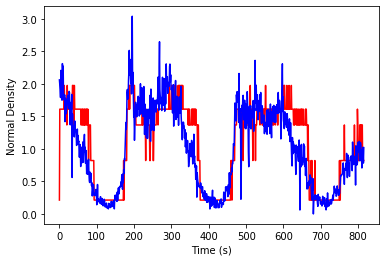

In [25]:
fuzzyinput_col_names=['var1cluster1','var1cluster2','var1cluster3','var1cluster4','var1cluster5',
                      'var2cluster1','var2cluster2','var2cluster3','var2cluster4','var2cluster5',
                      'var3cluster1','var3cluster2','var3cluster3','var3cluster4','var3cluster5',
                      'var4cluster1','var4cluster2','var4cluster3','var4cluster4','var4cluster5',
                     'outputvalue']
x=[]
f = open("cluster_dct.txt", "w")
f.write(str(num_input))
f.write(str(output_cluster))
f.write("\n")
f.close()

fd = open("mf_dct.txt", "w")
fd.close()

for i in range(num_var):
    initNN(i)

with open('mf_dct.txt', 'r') as f:
    i = f.read().split()
    for elem in i:
        try:
            x.append(float(elem))
        except ValueError:
            pass
print(len(x))

ruleCount=0
rules=[[-1 for i in range(num_var+1)] for j in range(pow(output_cluster,num_var))]

Outmf = [[0 for i in range(discreteSamplePoints)] for j in range(output_cluster+1)]


# Create fuzzytrain_ltsm
temp = np.array([[0.0 for i in range(train_num_line)] for j in range(num_input*output_cluster+1)]).T
# Array to dataframe :
fuzzytrain_ltsm = pd.DataFrame(temp,columns=fuzzyinput_col_names)

# Create fuzzytest_ltsm
temp = np.array([[0.0 for i in range(test_num_line)] for j in range(num_input*output_cluster+1)]).T
# Array to dataframe :
fuzzytest_ltsm = pd.DataFrame(temp,columns=fuzzyinput_col_names)

# Create fuzzytrain_mlp
temp = np.array([[0.0 for i in range(train_num_line)] for j in range(num_input*output_cluster+1)]).T
# Array to dataframe :
fuzzytrain_mlp = pd.DataFrame(temp,columns=fuzzyinput_col_names)

# Create fuzzytest_mlp
temp = np.array([[0.0 for i in range(test_num_line)] for j in range(num_input*output_cluster+1)]).T
# Array to dataframe :
fuzzytest_mlp = pd.DataFrame(temp,columns=fuzzyinput_col_names)


initNN1(x)

In [26]:
fuzzytest_mlp
fuzzytest_mlp_x=fuzzytest_mlp.iloc[:, 0:num_input*output_cluster]
fuzzytest_y=fuzzytest_mlp.iloc[:, num_input*output_cluster]
temp = np.array([[0 for i in range(test_num_line)] for j in range(output_cluster)]).T
for i in range(test_num_line):
#     print(fuzzytest_mlp_y[i])
    temp[i][int(fuzzytest_y[i])]=1
fuzzytest_mlp_y=temp
fuzzytest_mlp_y

array([[0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       ...,
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0]])

In [27]:
fuzzytrain_mlp
fuzzytrain_mlp_x=fuzzytrain_mlp.iloc[:, 0:num_input*output_cluster]
fuzzytrain_y=fuzzytrain_mlp.iloc[:, num_input*output_cluster]
temp = np.array([[0 for i in range(train_num_line)] for j in range(output_cluster)]).T

for i in range(train_num_line):
#     print(fuzzytrain_mlp_y[i])
    temp[i][int(fuzzytrain_y[i])]=1
fuzzytrain_mlp_y=temp
fuzzytrain_mlp_y

array([[0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       ...,
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0]])

In [28]:
fuzzytrain_ltsm

,var1cluster1,var1cluster2,var1cluster3,var1cluster4,var1cluster5,var2cluster1,var2cluster2,var2cluster3,var2cluster4,var2cluster5,...,var3cluster2,var3cluster3,var3cluster4,var3cluster5,var4cluster1,var4cluster2,var4cluster3,var4cluster4,var4cluster5,outputvalue
0,0.0,0.000000,0.040294,1.000000,0.038411,0.614581,0.101659,0.000502,0.000000,0.000000,...,0.240196,0.000434,0.000000,0.000000,0.218783,0.112172,0.000000,0.000000,0.000000,2.0608
1,0.0,0.000000,0.027910,0.948929,0.052897,0.000000,0.000000,0.030248,0.601538,0.286255,...,0.000028,0.077157,0.783684,0.030325,0.000000,0.000422,0.084530,0.931542,0.035358,1.9945
2,0.0,0.000000,0.027910,0.948929,0.052897,0.000000,0.000055,0.083558,1.000000,0.070335,...,0.052441,0.966266,0.105951,0.000000,0.000000,0.014227,0.451312,0.558179,0.008129,1.9118
3,0.0,0.000000,0.027910,0.948929,0.052897,0.000000,0.000000,0.030248,0.601538,0.286255,...,0.035914,0.986253,0.166871,0.000444,0.000000,0.034101,1.000000,0.132590,0.000000,1.7895
4,0.0,0.000000,0.027910,0.948929,0.052897,0.000000,0.000000,0.013762,0.157470,1.000000,...,0.010471,0.169975,1.000000,0.015448,0.000000,0.003494,0.125990,1.000000,0.024287,2.2069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811,0.0,0.040334,0.661072,0.022087,0.000000,0.000326,0.112364,0.758858,0.035710,0.000000,...,0.006639,0.000000,0.000000,0.000000,0.000000,0.071864,0.772321,0.061164,0.000000,0.9888
812,0.0,0.040334,0.661072,0.022087,0.000000,0.003241,0.182904,0.820164,0.024774,0.000000,...,0.648381,0.249492,0.019814,0.000000,0.000000,0.296432,0.526483,0.022140,0.000000,0.8202
813,0.0,0.028216,0.588903,0.031672,0.000000,0.019045,0.787494,0.118580,0.002502,0.000000,...,0.052441,0.966266,0.105951,0.000000,0.000000,0.102684,0.630369,0.043912,0.000000,1.0242
814,0.0,0.028216,0.588903,0.031672,0.000000,0.019045,0.787494,0.118580,0.002502,0.000000,...,0.025473,0.766899,0.310808,0.005162,0.000000,0.163479,0.566564,0.031208,0.000000,0.7816


In [29]:
fuzzytest_ltsm

,var1cluster1,var1cluster2,var1cluster3,var1cluster4,var1cluster5,var2cluster1,var2cluster2,var2cluster3,var2cluster4,var2cluster5,...,var3cluster2,var3cluster3,var3cluster4,var3cluster5,var4cluster1,var4cluster2,var4cluster3,var4cluster4,var4cluster5,outputvalue
0,0.0,0.000000,0.040294,1.000000,0.038411,0.614581,0.101659,0.000502,0.000000,0.000000,...,0.240196,0.000434,0.000000,0.000000,0.218783,0.112172,0.000000,0.000000,0.000000,2.0608
1,0.0,0.000000,0.027910,0.948929,0.052897,0.000000,0.000000,0.030248,0.601538,0.286255,...,0.000028,0.077157,0.783684,0.030325,0.000000,0.000422,0.084530,0.931542,0.035358,1.9945
2,0.0,0.000000,0.027910,0.948929,0.052897,0.000000,0.000055,0.083558,1.000000,0.070335,...,0.052441,0.966266,0.105951,0.000000,0.000000,0.014227,0.451312,0.558179,0.008129,1.9118
3,0.0,0.000000,0.027910,0.948929,0.052897,0.000000,0.000000,0.030248,0.601538,0.286255,...,0.035914,0.986253,0.166871,0.000444,0.000000,0.034101,1.000000,0.132590,0.000000,1.7895
4,0.0,0.000000,0.027910,0.948929,0.052897,0.000000,0.000000,0.013762,0.157470,1.000000,...,0.010471,0.169975,1.000000,0.015448,0.000000,0.003494,0.125990,1.000000,0.024287,2.2069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811,0.0,0.040334,0.661072,0.022087,0.000000,0.000326,0.112364,0.758858,0.035710,0.000000,...,0.006639,0.000000,0.000000,0.000000,0.000000,0.071864,0.772321,0.061164,0.000000,0.9888
812,0.0,0.040334,0.661072,0.022087,0.000000,0.003241,0.182904,0.820164,0.024774,0.000000,...,0.648381,0.249492,0.019814,0.000000,0.000000,0.296432,0.526483,0.022140,0.000000,0.8202
813,0.0,0.028216,0.588903,0.031672,0.000000,0.019045,0.787494,0.118580,0.002502,0.000000,...,0.052441,0.966266,0.105951,0.000000,0.000000,0.102684,0.630369,0.043912,0.000000,1.0242
814,0.0,0.028216,0.588903,0.031672,0.000000,0.019045,0.787494,0.118580,0.002502,0.000000,...,0.025473,0.766899,0.310808,0.005162,0.000000,0.163479,0.566564,0.031208,0.000000,0.7816


In [30]:
fuzzytrain_ltsm.values

array([[0.      , 0.      , 0.040294, ..., 0.      , 0.      , 2.0608  ],
       [0.      , 0.      , 0.02791 , ..., 0.931542, 0.035358, 1.9945  ],
       [0.      , 0.      , 0.02791 , ..., 0.558179, 0.008129, 1.9118  ],
       ...,
       [0.      , 0.028216, 0.588903, ..., 0.043912, 0.      , 1.0242  ],
       [0.      , 0.028216, 0.588903, ..., 0.031208, 0.      , 0.7816  ],
       [0.      , 0.028216, 0.588903, ..., 0.02214 , 0.      , 1.0188  ]])

In [31]:
trainX=[]
trainY=[]

n_future=5
n_past=10

for i in range(n_past, len(fuzzytrain_ltsm.values) - n_future +1):
    trainX.append(fuzzytrain_ltsm.values[i - n_past:i, 0:num_input*output_cluster])
    trainY.append(fuzzytrain_ltsm.values[i-1:i, num_input*output_cluster])
#     print("i + n_future-1=",i - 1)
#     print("i + n_future=",i)

trainX, trainY = np.array(trainX), np.array(trainY)
trainY

array([[2.0604],
       [2.2724],
       [1.8156],
       [1.8189],
       [1.7529],
       [1.8305],
       [1.4182],
       [1.7763],
       [1.7703],
       [1.5396],
       [1.5885],
       [1.6422],
       [1.7266],
       [1.8222],
       [1.6876],
       [1.8047],
       [1.622 ],
       [1.8839],
       [1.8634],
       [1.514 ],
       [1.3694],
       [1.7014],
       [1.7146],
       [1.5334],
       [1.8378],
       [0.5602],
       [1.5363],
       [1.2677],
       [1.3552],
       [1.3024],
       [1.2169],
       [1.1843],
       [1.4294],
       [1.3412],
       [1.2825],
       [1.2817],
       [1.2005],
       [1.0529],
       [1.1065],
       [1.3046],
       [1.0714],
       [1.2066],
       [1.1034],
       [1.1172],
       [0.875 ],
       [0.8719],
       [1.0683],
       [0.9769],
       [0.7291],
       [0.9873],
       [0.8605],
       [0.7839],
       [1.031 ],
       [0.9275],
       [1.1071],
       [0.7954],
       [0.9228],
       [1.1358],
       [1.2224

In [32]:
testX=[]
testY=[]

n_future=5
n_past=10

for i in range(n_past, len(fuzzytest_ltsm.values) - n_future +1):
    testX.append(fuzzytest_ltsm.values[i - n_past:i, 0:num_input*output_cluster])
    testY.append(fuzzytest_ltsm.values[i-1:i, num_input*output_cluster])
#     print("i + n_future-1=",i - 1)
#     print("i + n_future=",i)

testX, testY = np.array(testX), np.array(testY)
testY

array([[2.0604],
       [2.2724],
       [1.8156],
       [1.8189],
       [1.7529],
       [1.8305],
       [1.4182],
       [1.7763],
       [1.7703],
       [1.5396],
       [1.5885],
       [1.6422],
       [1.7266],
       [1.8222],
       [1.6876],
       [1.8047],
       [1.622 ],
       [1.8839],
       [1.8634],
       [1.514 ],
       [1.3694],
       [1.7014],
       [1.7146],
       [1.5334],
       [1.8378],
       [0.5602],
       [1.5363],
       [1.2677],
       [1.3552],
       [1.3024],
       [1.2169],
       [1.1843],
       [1.4294],
       [1.3412],
       [1.2825],
       [1.2817],
       [1.2005],
       [1.0529],
       [1.1065],
       [1.3046],
       [1.0714],
       [1.2066],
       [1.1034],
       [1.1172],
       [0.875 ],
       [0.8719],
       [1.0683],
       [0.9769],
       [0.7291],
       [0.9873],
       [0.8605],
       [0.7839],
       [1.031 ],
       [0.9275],
       [1.1071],
       [0.7954],
       [0.9228],
       [1.1358],
       [1.2224

In [33]:
model = Sequential()

model.add(LSTM(100,activation='relu',input_shape=(trainX.shape[1],trainX.shape[2]),return_sequences=True))
model.add(LSTM(100,activation='relu',return_sequences=True))
model.add(LSTM(100,activation='relu',return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam',loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 100)           48400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 100)           80400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 209,301
Trainable params: 209,301
Non-trainable params: 0
_________________________________________________________________


In [ ]:
##TRAINING DATA
history=model.fit(trainX,trainY, epochs=100, batch_size=16,validation_split=0.1,verbose=1)

Epoch 1/100
46/46 [==============================] - 30s 42ms/step - loss: 0.6827 - val_loss: 0.1034
Epoch 2/100
46/46 [==============================] - 1s 12ms/step - loss: 0.0587 - val_loss: 0.0936
Epoch 3/100
46/46 [==============================] - 1s 11ms/step - loss: 0.0790 - val_loss: 0.2774
Epoch 4/100
46/46 [==============================] - 1s 11ms/step - loss: 0.0713 - val_loss: 0.1890
Epoch 5/100
46/46 [==============================] - 1s 11ms/step - loss: 0.0568 - val_loss: 0.1712
Epoch 6/100
46/46 [==============================] - 1s 12ms/step - loss: 0.0541 - val_loss: 0.3980
Epoch 7/100
46/46 [==============================] - 1s 11ms/step - loss: 0.0473 - val_loss: 0.1840
Epoch 8/100
46/46 [==============================] - 1s 13ms/step - loss: 0.0539 - val_loss: 0.0937
Epoch 9/100
46/46 [==============================] - 1s 12ms/step - loss: 0.0611 - val_loss: 0.3916
Epoch 10/100
46/46 [==============================] - 1s 12ms/step - loss: 0.0447 - val_loss: 0.207

46/46 [==============================] - 1s 12ms/step - loss: 0.0180 - val_loss: 0.1735
Epoch 83/100
46/46 [==============================] - 1s 11ms/step - loss: 0.0216 - val_loss: 0.1847
Epoch 84/100
46/46 [==============================] - 0s 11ms/step - loss: 0.0199 - val_loss: 0.1538
Epoch 85/100
46/46 [==============================] - 0s 11ms/step - loss: 0.0162 - val_loss: 0.2954
Epoch 86/100
46/46 [==============================] - 1s 12ms/step - loss: 0.0185 - val_loss: 0.1969
Epoch 87/100
46/46 [==============================] - 1s 12ms/step - loss: 0.0178 - val_loss: 0.1583
Epoch 88/100
46/46 [==============================] - 1s 11ms/step - loss: 0.0195 - val_loss: 0.1586
Epoch 89/100
46/46 [==============================] - 1s 11ms/step - loss: 0.0222 - val_loss: 0.1745
Epoch 90/100
 1/46 [..............................] - ETA: 0s - loss: 0.0073

In [ ]:
forecast = model.predict(testX) #forecast
testY.shape

In [ ]:
time=[0]*len(forecast)
f = open("result_fuzzyinput_lstm.txt", "w")
    
print("\npredicted vs actual output")
f.write("predicted vs actual output\n")
for i in range(len(forecast)):
    print(" ", '{0:.2f}'.format(forecast[i][0]),"  ",'{0:.2f}'.format(testY[i][0]))
    f.write(str( '{0:.2f}'.format(forecast[i][0])))
    f.write("  ")
    f.write(str('{0:.2f}'.format(testY[i][0])))
    f.write("\n")
    time[i]=i

from matplotlib import pyplot as plt
plt.plot(time, forecast, 'r-')
plt.plot(time, testY, 'b-')
plt.xlabel("Time (s)")
plt.ylabel("Normal Density")
    
from sklearn.metrics import mean_squared_error
rms = mean_squared_error(testY, forecast)
print("RMSE = ",rms)
f.write("RMSE = ")
f.write(str(rms))
TestR2Value = r2_score(testY,forecast)
print("Testing Set R-Square=", TestR2Value)
f.write("R-Square=")
f.write(str(TestR2Value))
f.close()

In [ ]:
fuzzyvalue=[0]*len(forecast)
for i in range(len(forecast)):
    temp=0
    index=0
    for j in range(len(outputCluster)):
        if temp == 0:
            temp=abs(forecast[i]-outputCluster[j])
            index=j
        elif abs(forecast[i]-outputCluster[j]) < temp:
            temp=abs(forecast[i]-outputCluster[j])
            index=j
    if j == len(outputCluster)-1:
        fuzzyvalue[i]=outputCluster[index]
#         print(i," cluster",index)
fuzzyvalue

In [ ]:
time=[0]*len(forecast)
f = open("result_fuzzy_lstm.txt", "w")
    
print("\npredicted vs actual output")
f.write("predicted vs actual output\n")
for i in range(len(forecast)):
    print(" ", '{0:.2f}'.format(fuzzyvalue[i]),"  ",'{0:.2f}'.format(testY[i][0]))
    f.write(str( '{0:.2f}'.format(fuzzyvalue[i])))
    f.write("  ")
    f.write(str('{0:.2f}'.format(testY[i][0])))
    f.write("\n")
    time[i]=i

from matplotlib import pyplot as plt
plt.plot(time, fuzzyvalue, 'r-')
plt.plot(time, testY, 'b-')
plt.xlabel("Time (s)")
plt.ylabel("Normal Density")
    
from sklearn.metrics import mean_squared_error
rms = mean_squared_error(testY, fuzzyvalue)
print("RMSE = ",rms)
f.write("RMSE = ")
f.write(str(rms))
TestR2Value = r2_score(testY,fuzzyvalue)
print("Testing Set R-Square=", TestR2Value)
f.write("R-Square=")
f.write(str(TestR2Value))
f.close()

In [ ]:
outputCluster

In [ ]:
fuzzytest_mlp_y

In [ ]:
mlp=Sequential()

mlp.add(Dense(100,input_dim=num_input*output_cluster,activation='relu'))
mlp.add(Dense(100,activation='relu'))
mlp.add(Dense(100,activation='relu'))
mlp.add(Dropout(0.2))
mlp.add(Dense(output_cluster,activation='softmax'))
mlp.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
mlp.summary()


In [ ]:
mlp.fit(fuzzytrain_mlp_x,fuzzytrain_mlp_y.astype(int),batch_size=20,epochs=100,verbose=1)

prediction=mlp.predict(fuzzytest_mlp_x)
prediction

In [ ]:
length=len(prediction)
actualvalue=np.argmax(fuzzytest_mlp_y,axis=1)
predicted=np.argmax(prediction,axis=1)
correct=0
wrong=0
f = open("result_mlp.txt", "w")
for i in range(len(predicted)):
    if predicted[i] == actualvalue[i]:
        print("correct:",predicted[i]," ",actualvalue[i])
        f.write("correct: ")
        f.write(str(predicted[i]))
        f.write(" ")
        f.write(str(predicted[i]))
        f.write("\n")
        correct+=1
    else:
        print("wrong:",predicted[i]," ",actualvalue[i]) 
        f.write("wrong: ")
        f.write(str(predicted[i]))
        f.write(" ")
        f.write(str(actualvalue[i]))
        f.write("\n")
        wrong+=1
            
print("Classification rate:",correct/len(predicted))
f.write("\n")
f.write("Classification rate: ")
f.write(str(correct/len(predicted)))

f.close()

In [ ]:
fuzzytest_ltsm.iloc[:, num_input*output_cluster]

In [ ]:
time=[0]*len(prediction)
fuzzyPrediction=[0]*len(prediction)
fuzzyActual=fuzzytest_ltsm.iloc[:, num_input*output_cluster]
f = open("result_fuzzy_mlp.txt", "w")
print("\npredicted vs actual output")
f.write("predicted vs actual output\n")
for i in range(len(prediction)):
    fuzzyPrediction[i]=outputCluster[int(predicted[i])]
    print(" ", '{0:.2f}'.format(fuzzyPrediction[i]),"  ",'{0:.2f}'.format(fuzzyActual[i]))
    f.write(str( '{0:.2f}'.format(fuzzyPrediction[i])))
    f.write("  ")
    f.write(str('{0:.2f}'.format(fuzzyActual[i])))
    f.write("\n")
    time[i]=i

from matplotlib import pyplot as plt
plt.plot(time, fuzzyPrediction, 'r-')
plt.plot(time, fuzzyActual, 'b-')
plt.xlabel("Time (s)")
plt.ylabel("Normal Density")
    
from sklearn.metrics import mean_squared_error
rms = mean_squared_error(fuzzyActual, fuzzyPrediction)
print("RMSE = ",rms)
f.write("RMSE = ")
f.write(str(rms))
TestR2Value = r2_score(fuzzyActual,fuzzyPrediction)
print("Testing Set R-Square=", TestR2Value)
f.write("R-Square=")
f.write(str(TestR2Value))
f.close()